# opencv的cuda模块使用

参考：

1.[Getting Started with OpenCV CUDA Module](https://learnopencv.com/getting-started-opencv-cuda-modul/)

2.[OpenCV CUDA for Video Preprocessing](https://medium.com/dropout-analytics/opencv-cuda-for-videos-f3dcf346e398)

3.[详解python中GPU版本的opencv常用方法介绍](https://cloud.tencent.com/developer/article/1722771)


In [1]:
import cv2

In [2]:
#opencv版本情况
print(cv2.__version__)
print(cv2.getBuildInformation())
#配置所使用的GPU
cv2.cuda.setDevice(2)

4.4.0

General configuration for OpenCV 4.4.0 =====================================
  Version control:               unknown

  Extra modules:
    Location (extra):            /home/wushaogui/soft/opencv_gpu/opencv-4.4.0/opencv_contrib-4.4.0/modules
    Version control (extra):     unknown

  Platform:
    Timestamp:                   2021-02-02T05:31:17Z
    Host:                        Linux 4.15.0-132-generic x86_64
    CMake:                       3.19.3
    CMake generator:             Unix Makefiles
    CMake build tool:            /usr/bin/make
    Configuration:               RELEASE

  CPU/HW features:
    Baseline:                    SSE SSE2 SSE3
      requested:                 SSE3
    Dispatched code generation:  SSE4_1 SSE4_2 FP16 AVX AVX2 AVX512_SKX
      requested:                 SSE4_1 SSE4_2 AVX FP16 AVX2 AVX512_SKX
      SSE4_1 (17 files):         + SSSE3 SSE4_1
      SSE4_2 (2 files):          + SSSE3 SSE4_1 POPCNT SSE4_2
      FP16 (1 files):            + SSSE3 S

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

#显示图片
def show_images(images,closize=2,set_locator=False,titles=[]):
    
    rows=int(len(images)/closize)+1
    fig=plt.figure(figsize=(34,14))
    
    xmajorLocator = MultipleLocator(100)  # 将x主刻度标签设置为50的倍数
    xminorLocator = MultipleLocator(50) #将x轴次刻度标签设置为5的倍数
    
    ymajorLocator = MultipleLocator(100)
    yminorLocator = MultipleLocator(50) #将x轴次刻度标签设置为5的倍数
    
    for find,image in enumerate(images):
        if not np.any(image>1):
            image=image*255
        ax=fig.add_subplot(rows,closize,find+1)
        ax.imshow(image)
        
        if len(titles)==0:
            plt.title('{}-({})'.format(find,image.shape)) #图片大小作为标题
        else:
            plt.title('{}-({})'.format(titles[find],image.shape)) #自定义标题
        
        if set_locator:
            #主刻度
            ax.xaxis.set_major_locator(xmajorLocator)
            ax.yaxis.set_major_locator(ymajorLocator)
            
            #次刻度
            ax.xaxis.set_minor_locator(xminorLocator)
            ax.yaxis.set_minor_locator(yminorLocator)
            
            ax.xaxis.grid(True, which='major',linestyle='-.') #x坐标轴的网格使用主刻度
            ax.yaxis.grid(True, which='major',linestyle='-.') #x坐标轴的网格使用主刻度
    plt.show()

(876, 3218, 3)


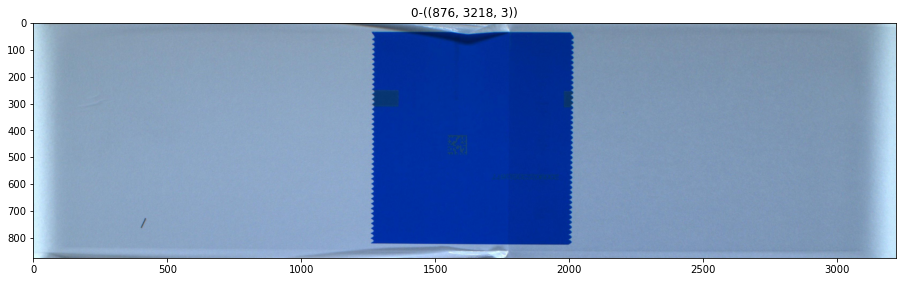

In [4]:
#opencv cuda使用
frame=cv2.imread('test.jpg')
print(frame.shape)
show_images([frame[...,::-1]])

In [5]:
#上传到gpu进行处理
gpu_frame=cv2.cuda_GpuMat()
gpu_frame.upload(frame)
print(gpu_frame.cudaPtr())

140326419300352


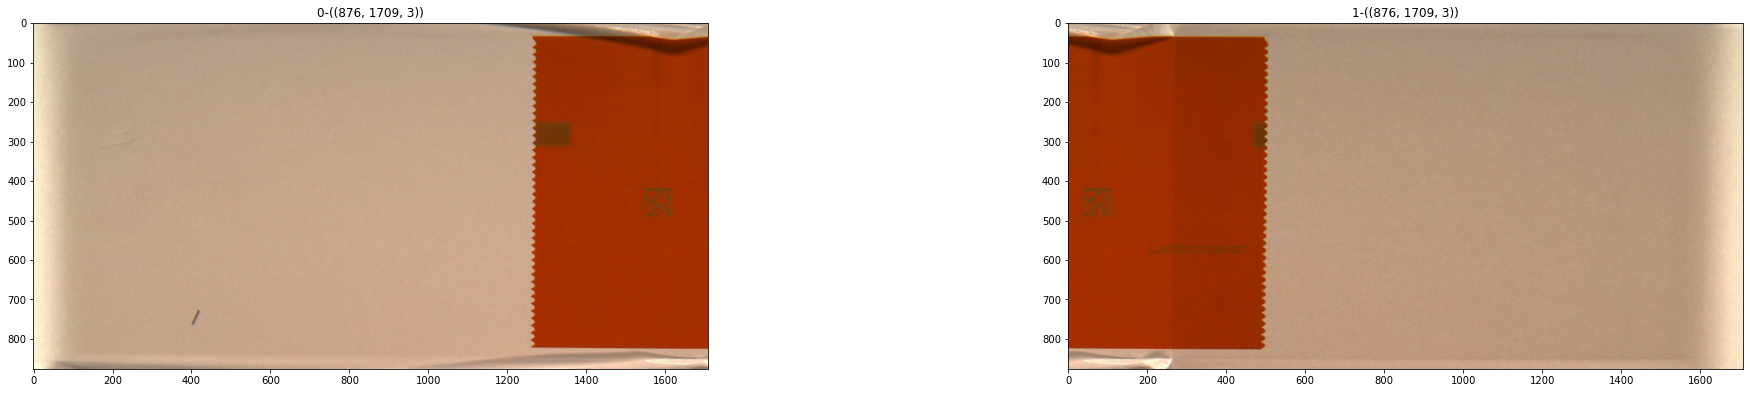

In [30]:
#截取部分区域
img_col=gpu_frame.size()[1]
img_row=gpu_frame.size()[0]
        
# 横向中线位置
middle_pos=int(img_row/2)
w_overlap_size=100

list_img_blocks=[]
# 添加分块信息
# 左半块
top=0
left=0
height=img_col
width=middle_pos+w_overlap_size
list_img_blocks.append(cv2.cuda_GpuMat(gpu_frame,[top, height+top], [left, width+left]).download())

# 右半块
top=0
left=middle_pos-w_overlap_size
height=img_col
width=img_row-middle_pos+100
list_img_blocks.append(cv2.cuda_GpuMat(gpu_frame,[top, height+top], [left, width+left]).download())     

show_images(list_img_blocks)

In [39]:
#查看图片的宽高
print(gpu_frame.size())
print(gpu_frame.type())

(3218, 876)
16


NameError: name 'new_gpu_frame' is not defined

(512, 1024, 3)


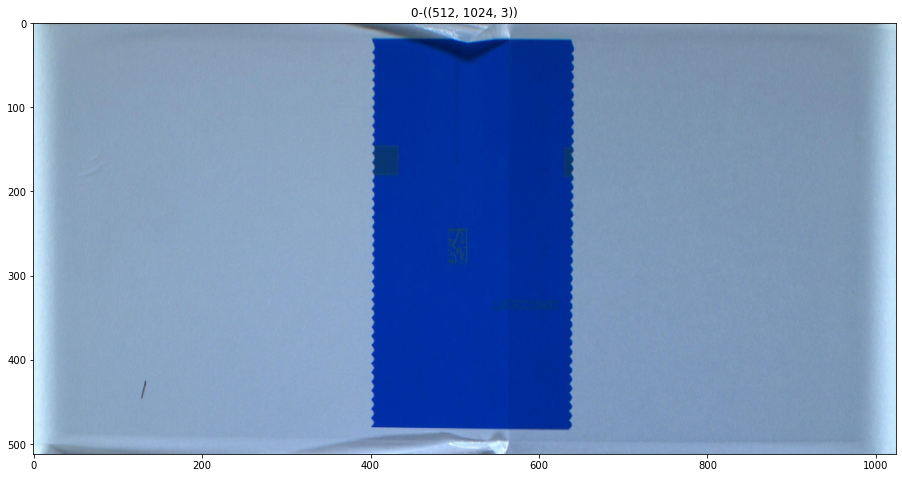

In [6]:
#resize
gpu_resframe=cv2.cuda.resize(gpu_frame,(1024,512))
cpu_resfram=gpu_resframe.download()
print(cpu_resfram.shape)
show_images([cpu_resfram[...,::-1]])

In [7]:
#颜色转换
luv = cv2.cuda.cvtColor(gpu_resframe, cv2.COLOR_BGR2LUV)
hsv = cv2.cuda.cvtColor(gpu_resframe, cv2.COLOR_BGR2HSV)
gray = cv2.cuda.cvtColor(gpu_resframe, cv2.COLOR_BGR2GRAY)
print(gray.download().shape)

(512, 1024)


(512, 1024)


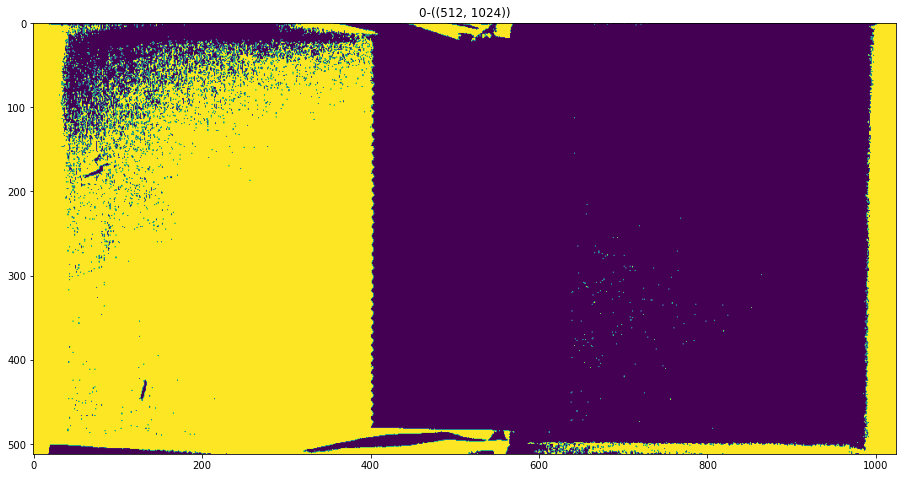

In [8]:
#cv.cuda + cv
canny = cv2.Canny(gray.download(), 155, 255)
all_thresh = cv2.cuda.threshold(gray, 155, 255, cv2.THRESH_BINARY)
thresh=all_thresh[1].download()
print(thresh.shape)
show_images([thresh])

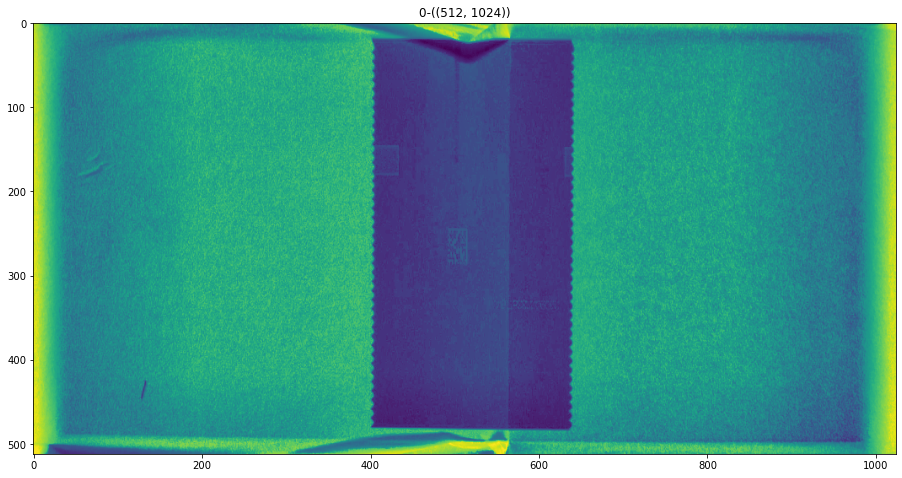

In [9]:
#createCLAHE
clahe = cv2.cuda.createCLAHE(clipLimit=5.0, tileGridSize=(8, 8))
dst = clahe.apply(gray, cv2.cuda_Stream.Null())

show_images([dst.download()])

In [10]:
#以下是cv2.cuda支持的操作
dir(cv2.cuda)

['ALPHA_ATOP',
 'ALPHA_ATOP_PREMUL',
 'ALPHA_IN',
 'ALPHA_IN_PREMUL',
 'ALPHA_OUT',
 'ALPHA_OUT_PREMUL',
 'ALPHA_OVER',
 'ALPHA_OVER_PREMUL',
 'ALPHA_PLUS',
 'ALPHA_PLUS_PREMUL',
 'ALPHA_PREMUL',
 'ALPHA_XOR',
 'ALPHA_XOR_PREMUL',
 'BroxOpticalFlow_create',
 'COLOR_BAYER_BG2BGR_MHT',
 'COLOR_BAYER_BG2GRAY_MHT',
 'COLOR_BAYER_BG2RGB_MHT',
 'COLOR_BAYER_GB2BGR_MHT',
 'COLOR_BAYER_GB2GRAY_MHT',
 'COLOR_BAYER_GB2RGB_MHT',
 'COLOR_BAYER_GR2BGR_MHT',
 'COLOR_BAYER_GR2GRAY_MHT',
 'COLOR_BAYER_GR2RGB_MHT',
 'COLOR_BAYER_RG2BGR_MHT',
 'COLOR_BAYER_RG2GRAY_MHT',
 'COLOR_BAYER_RG2RGB_MHT',
 'COLOR_BayerBG2BGR_MHT',
 'COLOR_BayerBG2GRAY_MHT',
 'COLOR_BayerBG2RGB_MHT',
 'COLOR_BayerGB2BGR_MHT',
 'COLOR_BayerGB2GRAY_MHT',
 'COLOR_BayerGB2RGB_MHT',
 'COLOR_BayerGR2BGR_MHT',
 'COLOR_BayerGR2GRAY_MHT',
 'COLOR_BayerGR2RGB_MHT',
 'COLOR_BayerRG2BGR_MHT',
 'COLOR_BayerRG2GRAY_MHT',
 'COLOR_BayerRG2RGB_MHT',
 'CascadeClassifier_create',
 'DEVICE_INFO_COMPUTE_MODE_DEFAULT',
 'DEVICE_INFO_COMPUTE_MODE_EXCLU

In [11]:
#以下是cv2.cuda_GpuMat支持的操作
GPU_mat = cv2.cuda_GpuMat()
dir(GPU_mat)

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'adjustROI',
 'assignTo',
 'channels',
 'clone',
 'col',
 'colRange',
 'convertTo',
 'copyTo',
 'create',
 'cudaPtr',
 'defaultAllocator',
 'depth',
 'download',
 'elemSize',
 'elemSize1',
 'empty',
 'isContinuous',
 'locateROI',
 'reshape',
 'row',
 'rowRange',
 'setDefaultAllocator',
 'setTo',
 'size',
 'step',
 'step1',
 'swap',
 'type',
 'updateContinuityFlag',
 'upload']

In [5]:
#比较cv2支持的操作
dir(cv2)

['',
 'ACCESS_FAST',
 'ACCESS_MASK',
 'ACCESS_READ',
 'ACCESS_RW',
 'ACCESS_WRITE',
 'ADAPTIVE_THRESH_GAUSSIAN_C',
 'ADAPTIVE_THRESH_MEAN_C',
 'AGAST_FEATURE_DETECTOR_AGAST_5_8',
 'AGAST_FEATURE_DETECTOR_AGAST_7_12D',
 'AGAST_FEATURE_DETECTOR_AGAST_7_12S',
 'AGAST_FEATURE_DETECTOR_NONMAX_SUPPRESSION',
 'AGAST_FEATURE_DETECTOR_OAST_9_16',
 'AGAST_FEATURE_DETECTOR_THRESHOLD',
 'AKAZE',
 'AKAZE_DESCRIPTOR_KAZE',
 'AKAZE_DESCRIPTOR_KAZE_UPRIGHT',
 'AKAZE_DESCRIPTOR_MLDB',
 'AKAZE_DESCRIPTOR_MLDB_UPRIGHT',
 'AKAZE_create',
 'AffineTransformer',
 'AgastFeatureDetector',
 'AgastFeatureDetector_AGAST_5_8',
 'AgastFeatureDetector_AGAST_7_12d',
 'AgastFeatureDetector_AGAST_7_12s',
 'AgastFeatureDetector_NONMAX_SUPPRESSION',
 'AgastFeatureDetector_OAST_9_16',
 'AgastFeatureDetector_THRESHOLD',
 'AgastFeatureDetector_create',
 'Algorithm',
 'AlignExposures',
 'AlignMTB',
 'AsyncArray',
 'BFMatcher',
 'BFMatcher_create',
 'BORDER_CONSTANT',
 'BORDER_DEFAULT',
 'BORDER_ISOLATED',
 'BORDER_REFLECT',
